In [ ]:
import torch
from einops import rearrange, repeat
from vitssm.models.upt._autoencoder import UPTVideoAutoencoder

model = UPTVideoAutoencoder()

x = torch.randn(1, 4, 3, 32, 32)
b, t, c, h, w = x.shape

upscale_factor = 1
t_out, h_out, w_out = u
output_pos = rearrange(
    torch.stack(torch.meshgrid([torch.arange(t), torch.arange(h), torch.arange(h)], indexing="ij")),
    "ndim time height width -> (time height width) ndim",
).float()

dims = torch.Tensor([4, 32, 32])
output_pos = output_pos / (dims - 1) * 1000
print(output_pos)
output_pos = repeat(output_pos, "... -> b ...", b=b)

model(x, output_pos).shape

tensor([[   0.0000,    0.0000,    0.0000],
        [   0.0000,    0.0000,   32.2581],
        [   0.0000,    0.0000,   64.5161],
        ...,
        [1000.0000, 2032.2581, 1967.7419],
        [1000.0000, 2032.2581, 2000.0000],
        [1000.0000, 2032.2581, 2032.2581]])


torch.Size([1, 4, 3, 64, 64])

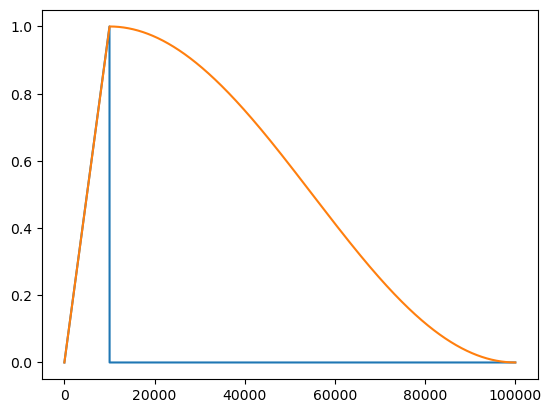

In [2]:
import matplotlib.pyplot as plt
import numpy as np

warmup_steps = 10000
decay_steps = 90000
scheduler_gamma = 0.0


def warm_and_exp_decay_lr(step: int):
    if step < warmup_steps:
        return step / warmup_steps

    return scheduler_gamma ** (step / decay_steps - warmup_steps / decay_steps)

def warm_and_cosine_decay_lr(step: int):
    if step < warmup_steps:
        return step / warmup_steps

    return scheduler_gamma + 0.5 * (1 - scheduler_gamma) * (1 + np.cos((step / decay_steps - warmup_steps / decay_steps) * np.pi))

x = list(range(100000))
y_exp = list(map(warm_and_exp_decay_lr, x))
y_cos = list(map(warm_and_cosine_decay_lr, x))
plt.plot(x, y_exp, label="exp")
plt.plot(x, y_cos, label="cos")

In [1]:
from vitssm.models.upt._autoencoder import UPTVAE_M, UPTVAE_T
from vitssm.models.upt._approximator import UPTA_M, UPTA_T
from vitssm.utils import count_parameters
import torch
from einops import rearrange, repeat

ae = UPTVAE_T(resolution=(4, 32, 32))
app = UPTA_T()

#x = torch.randn(1, 4, 3, 32, 32)
#
#b, f, c, h, w = x.shape
#x = rearrange(x, "b f c h w -> (b f) c h w")
#output_pos = rearrange(
#    torch.stack(torch.meshgrid([torch.arange(32), torch.arange(32)], indexing="ij")),
#    "ndim height width -> (height width) ndim",
#).float()
#
#x = ae.encode(x)
#print(x.shape)
#x = rearrange(x, "(b f) t e -> b f t e", b=b, f=f)
#x = app(x)
#print(x.shape)

print("autoencoder: ", count_parameters(ae))
print("approximator: ", count_parameters(app))
print("total: ", count_parameters(ae) + count_parameters(app))

autoencoder:  2038275
approximator:  894720
total:  2932995


In [1]:
from vitssm.models.dit import DiT_models
from vitssm.utils import count_parameters

model = DiT_models["DiT_M_1"]()
model.initialize_weights()
count_parameters(model)

1057444

In [9]:
from vitssm.models.diffusion import create_diffusion
import torch.nn as nn
import torch

diff = create_diffusion("trailing4")
diff.betas

ImportError: cannot import name 'CaptionProjection' from 'diffusers.models.embeddings' (/home/david/micromamba/envs/vitssm/lib/python3.12/site-packages/diffusers/models/embeddings.py)

In [12]:
import numpy as np
import pandas as pd
import wandb
from vitssm.data import get_dataloaders_next_frame
from vitssm.utils.visual import model_output_to_video
from omegaconf import OmegaConf
import random

config = OmegaConf.load("configs/DIT/dit_tiny_config.yml")
_, eval_loader = get_dataloaders_next_frame(config.dataset)

run = wandb.init(project="test")

for step in range(0, 10, 2):
    rollout_data = []
    roll_steps=[]
    for rollout_step in range(1, 65):
        rollout_data.append(random.randint(1, 10))
        roll_steps.append(rollout_step)
    wandb.log({"ssim": rollout_data, "rollout_step": roll_steps}, step=step)

    #table = wandb.Table(data=rollout_data, columns=["step", "ssim", "psnr"])
    # axes are (time, channel, height, width)
    frames = next(iter(eval_loader))[1]
    run.log(
        {
            #"rollout_metrics": rollout_data,
            #"ssim": wandb.plot.line(table, x="step", y="ssim", title="test over rollout steps"),
            #"psnr": wandb.plot.line(table, x="step", y="test", title="test over rollout steps"),
            "rollout: ground truth vs. prediction": [
                wandb.Video(model_output_to_video(frames[step]),fps=4),
                wandb.Video(model_output_to_video(frames[step+1]), fps=4),
            ],
        }, 
        step=step
    )

run.finish()

In [5]:
model_output_to_video(frames[0]).shape

(16, 32, 32, 3)

In [10]:
run.finish()